<a href="https://colab.research.google.com/github/GDharan10/Tips-dataset-analysis/blob/main/1_Tips_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librarys**

In [1]:
import pandas as pd
import numpy as np

#Statistic
from scipy import stats

#Machine Learning
import statsmodels.api as sm

#Visualization
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

In [24]:
df = sns.load_dataset('tips')

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


# **DataFrame observation**


In [4]:
continuous_columns = ["total_bill", "tip"]
category_columns = ["sex",	"smoker",	"day", "time", "size"]

#Unsupervised

# **Data cleaning using pandas**


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [6]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

# **Hypothesis testing / Statistical analysis**


Continuous column - Central Limit Theorem, 1-Tailed Test (one-sample t-test)

Continuous vs. Continuous - Correlation, 2-Tailed Test (two-sample t-test)

Continuous vs. Categorical - ANOVA (Analysis of Variance)

Categorical vs. Categorical - Chi-Square Test

In [7]:
def hypothesisTesting(continuous_columns = [], category_columns = [], sampling_rate = 0.20, sampling_frac=0.05):
  #Central Limit Theorem
  oneContinesColumn_result = {}
  hypothesis_df = pd.DataFrame(columns=df.columns, index=df.columns)
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      population=df[column].values
      population_mean = population.mean()
      sample_mean=[]
      for i in range(40):
        sample=np.random.choice(population,samplesize)
        sample_mean.append(sample.mean())
      oneContinesColumn_result[column] = {
                                          "Population Mean": population_mean,
                                          "Sample Means": {np.mean(sample_mean)}
                                          }

  #1-Tailed Test
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      H0_accepted = 0
      H0_rejected = 0
      for i in range(samplesize):
        sample=df[column].sample(frac=sampling_frac)
        t_test,p_value=stats.ttest_1samp(sample,df[column].mean())
        if p_value > 0.5:
          H0_accepted += 1
        else:
          H0_rejected += 1

      if H0_accepted > H0_rejected:
        oneContinesColumn_result[column].update( {
                                            "H0_accepted": H0_accepted,
                                            "H0_rejected": H0_rejected,
                                            "Conclusion": "H0 is accepted, Ha is rejected, There is no significant effect"
                                          } )
      else:
          oneContinesColumn_result[column].update( {
                                              "H0_accepted": H0_accepted,
                                              "H0_rejected": H0_rejected,
                                              "Conclusion": "H0 is rejected, Ha is accepted, There is a significant effect"
                                              } )

  #2-Tailed Test
  for i in range(len(continuous_columns) - 1):
      column_1 = continuous_columns[i]
      for column_2 in continuous_columns[i+1:]:
        H0_accepted = 0
        H0_rejected = 0
        for i in range(20):
          sample1 = df[column_1].sample(frac=sampling_frac)
          sample2 = df[column_2].sample(frac=sampling_frac)
          t_test, p_value = stats.ttest_ind(sample1, sample2)
          if p_value > 0.5:
            H0_accepted += 1
          else:
            H0_rejected += 1

        if H0_accepted > H0_rejected:
          #H0 is accepted, Ha is rejected, There is no significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
          hypothesis_df[column_1][column_2] = "H0 is accepted"
          hypothesis_df[column_2][column_1] = "H0 is accepted"
        else:
          #H0 is rejected, Ha is accepted, There is a significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
            hypothesis_df[column_1][column_2] = "H0 is rejected"
            hypothesis_df[column_2][column_1] = "H0 is rejected"

  #Chi-Square Test
  if category_columns:
    for i in range(len(category_columns) - 1):
        column_1 = category_columns[i]
        for column_2 in category_columns[i + 1:]:
            data = pd.crosstab(df[column_1], df[column_2])
            observed_values = data.values
            chi2_stat, p_value, _, _ = stats.chi2_contingency(observed_values)

            if p_value > 0.05:
                # H0 is accepted, There is no relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "H0 is accepted"
                hypothesis_df[column_2][column_1] = "H0 is accepted"
            else:
                # H0 is rejected, There is a relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "H0 is rejected"
                hypothesis_df[column_2][column_1] = "H0 is rejected"

  #ANOVA
  if continuous_columns and category_columns:
    for category_column in category_columns:
      for continuous_column in continuous_columns:
        group = df[category_column].unique()
        data = {}
        for i in group:
          data[i]=df[continuous_column][df[category_column]==i]

        f_value, p_value = stats.f_oneway(*[data[i] for i in group])
        if p_value > 0.05:
            # H0 is accepted, There is no relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "H0 is accepted"
            hypothesis_df[continuous_column][category_column] = "H0 is accepted"
        else:
            # H0 is rejected, There is a relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "H0 is rejected"
            hypothesis_df[continuous_column][category_column] = "H0 is rejected"

  return oneContinesColumn_result, hypothesis_df

# Correlation

In [8]:
df.corr()

<ipython-input-8-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


# **Result Hypothesis**

In [9]:
ContinesColumn_result, comperativeColumn_result = hypothesisTesting(continuous_columns , category_columns)

In [10]:
ContinesColumn_result_df = pd.DataFrame(ContinesColumn_result)
ContinesColumn_result_df

,total_bill,tip
Population Mean,19.785943,2.998279
Sample Means,{19.70240104166667},{2.9690052083333334}
H0_accepted,19,24
H0_rejected,29,24
Conclusion,"H0 is rejected, Ha is accepted, There is a sig...","H0 is rejected, Ha is accepted, There is a sig..."


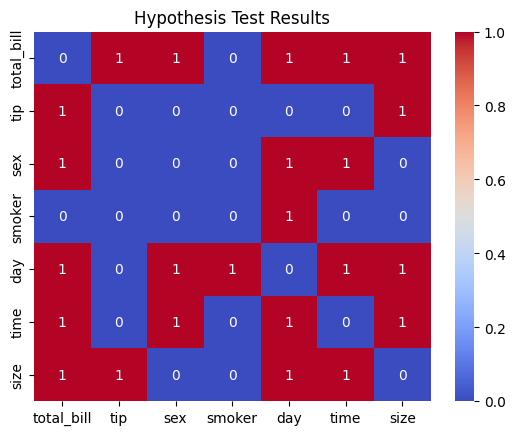

In [11]:
# Create a heatmap
sns.heatmap(comperativeColumn_result == 'H0 is rejected', annot=True, cmap='coolwarm')
plt.title('Hypothesis Test Results')
plt.show()

# **Data Visualization**

In [ ]:
correlation_matrix = df.corr()
fig = px.imshow(correlation_matrix, color_continuous_scale='Viridis',
                title="Correlation Matrix")
fig.show()

<ipython-input-14-ebcbbf98ef30>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [25]:
fig = px.scatter(df, x='total_bill', y='tip', color='sex', title='Total Bill vs Tip',
                 labels={'total_bill': 'Total Bill', 'tip': 'Tip', 'sex': 'Sex'})
fig.show()

# **Preprocessing**

In [12]:
df.time.unique()

['Dinner', 'Lunch']
Categories (2, object): ['Lunch', 'Dinner']

In [13]:
# Replacing categorical values with numerical equivalents
df['sex'] = df['sex'].map({'Female': 101, 'Male': 102})
df['smoker'] = df['smoker'].map({'No': 201, 'Yes': 202})
df['day'] = df['day'].replace({'Sun': 301, 'Thur': 302, 'Fri': 303, 'Sat' : 304})
df['time'] = df['time'].replace({'Dinner': 401, 'Lunch': 402})
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,101,201,301,401,2
1,10.34,1.66,102,201,301,401,3
2,21.01,3.50,102,201,301,401,3
3,23.68,3.31,102,201,301,401,2
4,24.59,3.61,101,201,301,401,4
...,...,...,...,...,...,...,...
239,29.03,5.92,102,201,304,401,3
240,27.18,2.00,101,202,304,401,2
241,22.67,2.00,102,202,304,401,2
242,17.82,1.75,102,201,304,401,2


# **Machine Learning**

In [ ]:
# 1 data availability
# 2 separating independent and dependent
# 3 identifying algorithms/Model
# 4 training
# 5 evaluation

In [ ]:
wcss = []
for i in range(1,245):
  model = KMeans(i)
  model.fit(df)
  wcss.append(model.inertia_)
print(wcss)

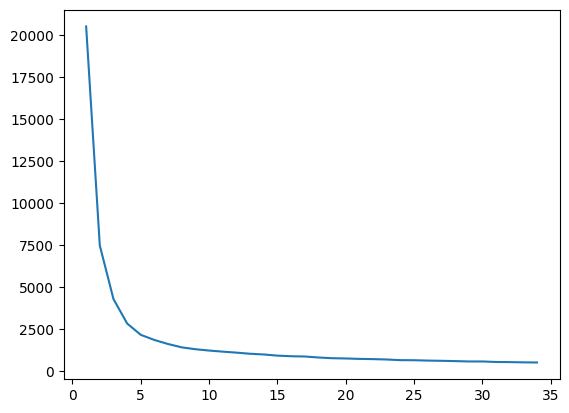

In [15]:
plt.plot(range(1,35), wcss[0:34])
plt.show()

In [16]:
result = KMeans(15).fit(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
identify_cluster = result.fit_predict(df)
df['cluster'] = identify_cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
df.cluster.value_counts()

5     32
4     29
2     28
0     22
13    21
10    18
14    17
8     17
9     15
1     11
6     11
7      8
12     8
11     4
3      3
Name: cluster, dtype: int64

In [19]:
df

,total_bill,tip,sex,smoker,day,time,size,cluster
0,16.99,1.01,101,201,301,401,2,5
1,10.34,1.66,102,201,301,401,3,13
2,21.01,3.50,102,201,301,401,3,2
3,23.68,3.31,102,201,301,401,2,14
4,24.59,3.61,101,201,301,401,4,14
...,...,...,...,...,...,...,...,...
239,29.03,5.92,102,201,304,401,3,9
240,27.18,2.00,101,202,304,401,2,6
241,22.67,2.00,102,202,304,401,2,2
242,17.82,1.75,102,201,304,401,2,8


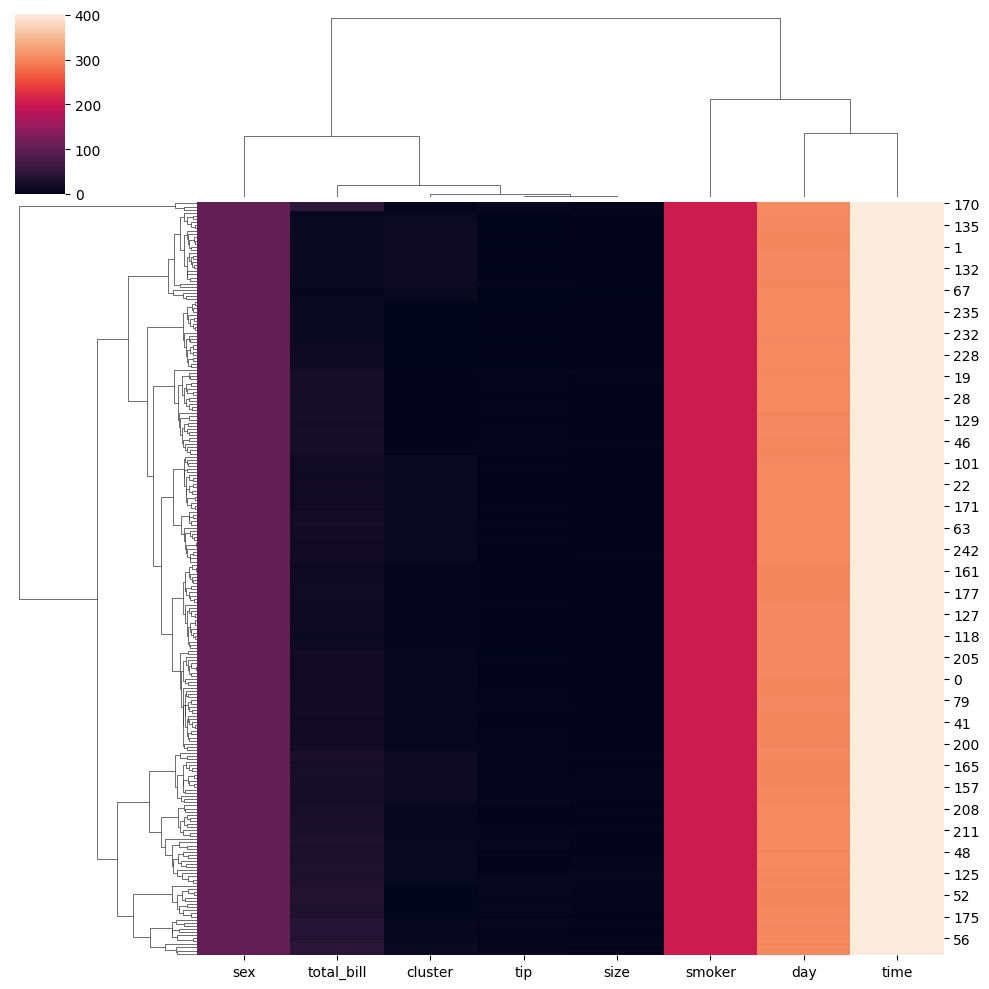

In [20]:
sns.clustermap(df)


In [21]:
df[df['cluster'] == 3]

,total_bill,tip,sex,smoker,day,time,size,cluster
59,48.27,6.73,102,201,304,401,4,3
170,50.81,10.00,102,202,304,401,3,3
212,48.33,9.00,102,201,304,401,4,3


In [22]:
pd.set_option('display.max_rows',None)
df

,total_bill,tip,sex,smoker,day,time,size,cluster
0,16.99,1.01,101,201,301,401,2,5
1,10.34,1.66,102,201,301,401,3,13
2,21.01,3.50,102,201,301,401,3,2
3,23.68,3.31,102,201,301,401,2,14
4,24.59,3.61,101,201,301,401,4,14
5,25.29,4.71,102,201,301,401,4,14
6,8.77,2.00,102,201,301,401,2,13
7,26.88,3.12,102,201,301,401,4,14
8,15.04,1.96,102,201,301,401,2,4
9,14.78,3.23,102,201,301,401,2,4
